In [24]:
"""
PAIR004 - Dilbar (1999) vs. Dilbar (2018)
---------------------------------
Purpose: 
    1. Quantify how strongly the original and derived tracks co-move in visibility. 
    2. Check whether Spotify and YT dynamics behave similarly (trend-wise). 
Method: 
    1. Pearson correlation test (linear dependence)
    2. Spearman rank correlation test (robust to outliers, also nonlinear!)
    3. I will log-transform YT views (to handle any potential skew). 
Possible Interpretation:
    1. High r -> shared visibility trajectory (possible spillover)
    2. Low r -> platform divergence or other rationale. 
"""

'\nPAIR004 - Dilbar (1999) vs. Dilbar (2018)\n---------------------------------\nPurpose: \n    1. Quantify how strongly the original and derived tracks co-move in visibility. \n    2. Check whether Spotify and YT dynamics behave similarly (trend-wise). \nMethod: \n    1. Pearson correlation test (linear dependence)\n    2. Spearman rank correlation test (robust to outliers, also nonlinear!)\n    3. I will log-transform YT views (to handle any potential skew). \nPossible Interpretation:\n    1. High r -> shared visibility trajectory (possible spillover)\n    2. Low r -> platform divergence or other rationale. \n'

In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [28]:
raw = Path("../data/raw/chartmetric_exports/PAIR004")
pair_id = "PAIR004"
save_fig = True
fig_dir = Path("../reports/visualizations")
fig_dir.mkdir(parents=True, exist_ok=True) ## Making the parent directory to store my visualizations, and avoid any errors. 
overlap_only = True

In [29]:
## Pattern for expected filenames

filename = re.compile(
    r"chartmetric_(PAIR\d+)_(original|derived)_(spotify|youtube)_(streams|popularity|likes|views)\.csv", flags=re.IGNORECASE
)

In [30]:
## Loading one chartmetric file and standardizing column names (for convenience purposes). 

def load_chartmetric_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower() ## Converting header to lower-case (simplicity sake)
    
    ## 1. Parsing the date. 
    if "date" not in df.columns:
        raise ValueError(f"No 'Date' column in file: {path.name}")
    df["date"] = pd.to_datetime(df["date"])
    
    ## 2. Finding the main value column. 
    for candidate in ("spotify streams", "popularity", "likes", "total views"):
        if candidate in df.columns:
            value_column = candidate
            break
        else:
            value_column = next(c for c in df.columns if c not in ("date", "change")) ## Fallback. 

    ## 3. Here, I'm just making sure change exists even when it isn't provided in the data (in-case). 
    if "change" not in df.columns:
        df["change"] = np.nan
    
    return df[["date", value_column, "change"]].rename(columns={value_column: "value"})

In [31]:
files = [p for p in raw.glob(f"chartmetric_{pair_id}_*.csv") if filename.match(p.name)] ## Collecting all files for `PAIR001`. 

## Here, I'm mapping the metrics to a canonical suffix used in column names. 
canon = {
    ("spotify", "streams"): "sp_streams",
    ("spotify", "popularity"): "sp_pop", 
    ("youtube", "likes"): "yt_likes",
    ("youtube", "views"): "yt_views"
}

In [32]:
## Building wider frames to store data. 

role_frames = {}
for role in ("original", "derived"):
    role_df = None
    for p in files:
        m = filename.match(p.name)
        if not m:
            continue
        role_m, platform, metric = m.group(2).lower(), m.group(3).lower(), m.group(4).lower()
        if role_m != role:
            continue
        key = (platform, metric)
        if key not in canon:
            continue
            
        ## 
        dfm = load_chartmetric_csv(p)
        dfm = dfm.rename(columns={
            "value": f"{role}_{canon[key]}", 
            "change": f"{role}_{canon[key]}_chg"
        })
        
        role_df = dfm if role_df is None else role_df.merge(dfm, on="date", how="outer")
        
        if role_df is None:
            raise ValueError(f"No files assembled for role={role} in {pair_id}")
        role_frames[role] = role_df.sort_values("date")

In [33]:
## Now, I'm planning to merge the data for the pairs (original and derived). 

full_data = role_frames["original"].merge(role_frames["derived"], on="date", how="outer").sort_values("date")

In [34]:
## Building overlap for correlation. I'm only counting dates that both songs share. Since I am trying to find how the derived affects the original's visibility and metrics. 

if overlap_only:
    candidate_columns = [
        "original_sp_pop", "derived_sp_pop", 
        "original_sp_streams", "derived_sp_streams", 
        "original_yt_views", "derived_yt_views", 
        "original_yt_likes", "derived_yt_likes"
    ]
    
    have_columns = [c for c in candidate_columns if c in full_data.columns]
    
    mask = np.ones(len(full_data), dtype=bool)
    for c in have_columns:
        mask &= full_data[c].notna()
    df = full_data.loc[mask].copy()
else:
    df = full_data.copy().ffill()

In [35]:
## Return natural log for YT total views. 

for side in ("original", "derived"):
    column = f"{side}_yt_views"
    if column in df.columns:
        df[f"log_{column}"] = np.log1p(df[column])

results = {}

In [36]:
def correlation_pair(name: str, x: pd.Series, y: pd.Series):
    if x.notna().sum() > 2 and y.notna().sum() > 2:
        results[name] = {
            "pearson": float(x.corr(y)),
            "spearman": float(x.rank().corr(y.rank()))
        }

In [37]:
## Level Measurements - Spotify Popularity

if {"original_sp_pop", "derived_sp_pop"}.issubset(df.columns):
    correlation_pair("levels_spotify_popularity", df["original_sp_pop"], df["derived_sp_pop"])
    
## Level Measurements - Spotify Streams

if {"original_sp_streams", "derived_sp_streams"}.issubset(df.columns):
    correlation_pair("levels_spotify_streams", df["original_sp_streams"], df["derived_sp_streams"])
    
## Level Measurements - YouTube Total Views

if {"log_original_yt_views", "log_derived_yt_views"}.issubset(df.columns):
    correlation_pair("levels_youtube_totalviews_log", df["log_original_yt_views"], df["log_derived_yt_views"])

## Level Measurements - YouTube Likes

if {"log_original_yt_likes", "log_derived_yt_likes"}.issubset(df.columns):
    correlation_pair("levels_youtube_totalviews_likes", df["log_original_yt_likes"], df["log_derived_yt_likes"])

In [38]:
## Changes in Measurements:

def correlation_change(tag: str):
    c1, c2 = f"original_{tag}_chg", f"derived_{tag}_chg"
    if {c1, c2}.issubset(df.columns):
        correlation_pair(f"changes_{tag}", df[c1], df[c2])
        
for tag in ("sp_pop", "sp_streams", "yt_views", "yt_likes"):
    correlation_change(tag)

In [39]:
print(f"Print Correlation (Date Overlap) - {pair_id}")
print(f"--------------------------------------------")
if not results:
    print("No comparable series found. Need to check my files/columns")
else: 
    for name, statistics in results.items():
        print(f"{name:30s} | Pearson: {statistics['pearson']:+.3f} | Spearman: {statistics['spearman']:+.3f}")

Print Correlation (Date Overlap) - PAIR004
--------------------------------------------
levels_spotify_popularity      | Pearson: +0.953 | Spearman: +0.959
levels_spotify_streams         | Pearson: +0.959 | Spearman: +1.000
levels_youtube_totalviews_log  | Pearson: +0.031 | Spearman: +0.956
changes_sp_pop                 | Pearson: +0.152 | Spearman: +0.176
changes_sp_streams             | Pearson: +0.673 | Spearman: +0.812
changes_yt_views               | Pearson: +0.007 | Spearman: +0.164
changes_yt_likes               | Pearson: +0.326 | Spearman: +0.596


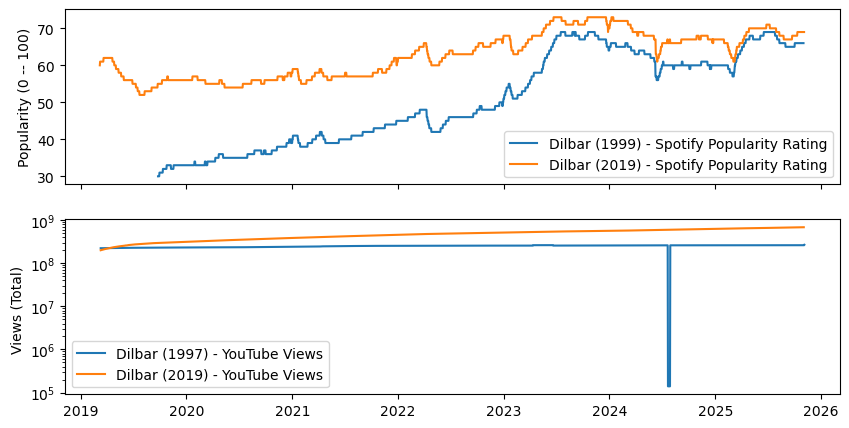

In [41]:
## Plotting visualizations

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

if {"original_sp_pop", "derived_sp_pop"}.issubset(full_data.columns):
    ax[0].plot(full_data["date"], full_data["original_sp_pop"], label="Dilbar (1999) - Spotify Popularity Rating")
    ax[0].plot(full_data["date"], full_data["derived_sp_pop"], label="Dilbar (2019) - Spotify Popularity Rating")
    ax[0].set_ylabel("Popularity (0 -- 100)")
    ax[0].legend()

if {"original_yt_views", "derived_yt_views"}.issubset(full_data.columns):
    ax[1].plot(full_data["date"], full_data["original_yt_views"], label="Dilbar (1997) - YouTube Views")
    ax[1].plot(full_data["date"], full_data["derived_yt_views"], label="Dilbar (2019) - YouTube Views")
    ax[1].set_ylabel("Views (Total) ")
    ax[1].set_yscale("log")
    ax[1].legend()

In [42]:
fig.suptitle(f"{pair_id} - Visibility Co-Movement")
result = fig_dir / f"{pair_id}_visibility_comovement.png"
if save_fig:
    fig.savefig(result, dpi=150)
    print("[SAVED]", result)
plt.show()

[SAVED] ../reports/visualizations/PAIR004_visibility_comovement.png
